In [7]:
#from preprocessing import Preprocess
from transformers import BertModel
import matplotlib.pyplot as plt
import torch
import pandas as pd
from torch import tensor

# df = Preprocess()
df = pd.read_excel('file_small.xlsx')
df['BERT-Tokenized']=df['BERT-Tokenized'].apply(eval)
df['TokenID']=df['TokenID'].apply(eval)
df['SegmentID']=df['SegmentID'].apply(eval)
df['Token-Tensor']=df['Token-Tensor'].apply(lambda x: eval(x))
df['Segment-Tensor']=df['Segment-Tensor'].apply(lambda x: eval(x))
df.head()

,Review,Feature List,BERT-Tokenized,TokenID,SegmentID,Token-Tensor,Segment-Tensor
0,BLUETOOTH DOES NOT WORK ON THIS PHONE.,['BLUETOOTH'],"[[CLS], blue, ##tooth, does, not, work, on, th...","[101, 2630, 19392, 2515, 2025, 2147, 2006, 202...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[tensor(101), tensor(2630), tensor(19392), te...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
1,YOU STILL HAVE TO CLEAN THE THING.,['CLEAN'],"[[CLS], you, still, have, to, clean, the, thin...","[101, 2017, 2145, 2031, 2000, 4550, 1996, 2518...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[tensor(101), tensor(2017), tensor(2145), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
2,canon s g does it consistently.,['delay'],"[[CLS], canon, s, g, does, it, consistently, ....","[101, 9330, 1055, 1043, 2515, 2009, 10862, 101...","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[[tensor(101), tensor(9330), tensor(1055), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
3,This is a fantastic tool to use.,['tool'],"[[CLS], this, is, a, fantastic, tool, to, use,...","[101, 2023, 2003, 1037, 10392, 6994, 2000, 222...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[tensor(101), tensor(2023), tensor(2003), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
4,I HAVE NEVER HAD AN ODOR PROBLEM.,['ODOR'],"[[CLS], i, have, never, had, an, odor, problem...","[101, 1045, 2031, 2196, 2018, 2019, 19255, 329...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[[tensor(101), tensor(1045), tensor(2031), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


# 3. Extracting Embeddings
## 3.1. Running BERT on our text
Next we need to convert our data to torch tensors and call the BERT model. The BERT PyTorch interface requires that the data be in torch tensors rather than Python lists, so we convert the lists here - this does not change the shape or the data.

Calling from_pretrained will fetch the model from the internet. When we load the bert-base-uncased, we see the definition of the model printed in the logging. The model is a deep neural network with 12 layers! Explaining the layers and their functions is outside the scope of this post, and you can skip over this output for now.

model.eval() puts our model in evaluation mode as opposed to training mode. In this case, evaluation mode turns off dropout regularization which is used in training.

In [2]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True)

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

Next, let’s evaluate BERT on our example text, and fetch the hidden states of the network!

Side note: torch.no_grad tells PyTorch not to construct the compute graph during this forward pass (since we won’t be running backprop here)–this just reduces memory consumption and speeds things up a little.

In [4]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

## 3.2. Understanding the Output
The full set of hidden states for this model, stored in the object hidden_states, is a little dizzying. This object has four dimensions, in the following order:

* The layer number (13 layers)
* The batch number (1 sentence)
* The word / token number (22 tokens in our sentence)
* The hidden unit / feature number (768 features)

Wait, 13 layers? Doesn’t BERT only have 12? It’s 13 because the first element is the input embeddings, the rest is the outputs of each of BERT’s 12 layers.

That’s 219,648 unique values just to represent our one sentence!

The second dimension, the batch size, is used when submitting multiple sentences to the model at once; here, though, we just have one example sentence.

In [5]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 10
Number of hidden units: 768


Let’s take a quick look at the range of values for a given layer and token.

You’ll find that the range is fairly similar for all layers and tokens, with the majority of values falling between [-2, 2], and a small smattering of values around -10.

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

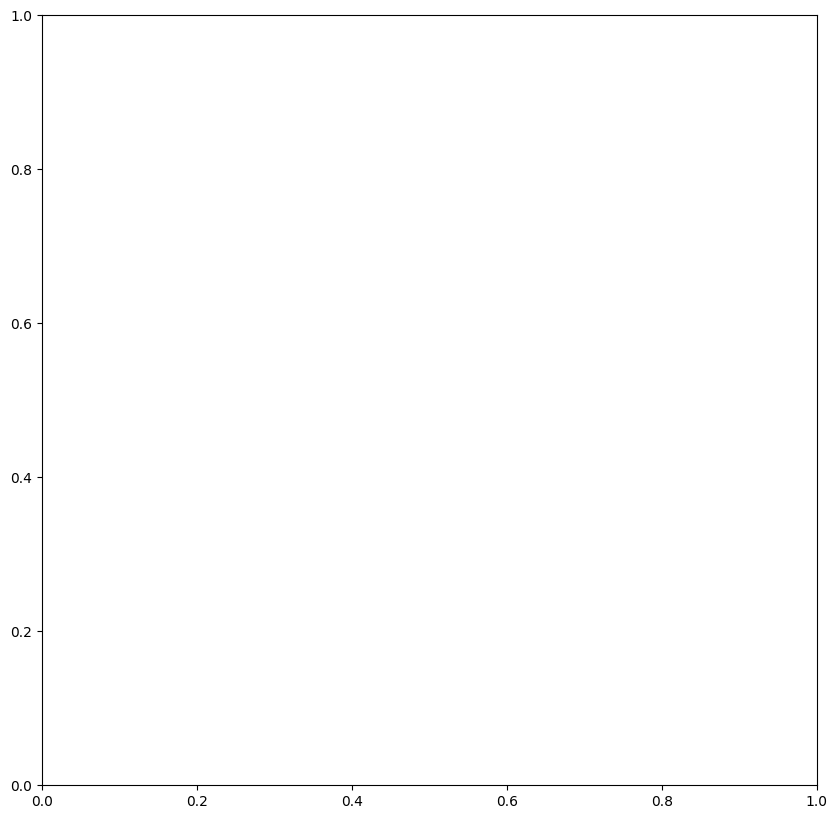

In [9]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = hidden_states[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()

Grouping the values by layer makes sense for the model, but for our purposes we want it grouped by token.

Current dimensions:

[# layers, # batches, # tokens, # features]

Desired dimensions:

[# tokens, # layers, # features]

Luckily, PyTorch includes the permute function for easily rearranging the dimensions of a tensor.

However, the first dimension is currently a Python list!

In [10]:
# `hidden_states` is a Python list.
print('      Type of hidden_states: ', type(hidden_states))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', hidden_states[0].size())

      Type of hidden_states:  <class 'tuple'>
Tensor shape for each layer:  torch.Size([1, 10, 768])


Let’s combine the layers to make this one whole big tensor.

In [14]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(hidden_states, dim=0)

token_embeddings.size()

torch.Size([13, 1, 10, 768])

Let’s get rid of the “batches” dimension since we don’t need it.

In [15]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()

torch.Size([13, 10, 768])

Finally, we can switch around the “layers” and “tokens” dimensions with permute.

In [16]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()

torch.Size([10, 13, 768])

## 3.3. Creating word and sentence vectors from hidden states
Now, what do we do with these hidden states? We would like to get individual vectors for each of our tokens, or perhaps a single vector representation of the whole sentence, but for each token of our input we have 13 separate vectors each of length 768.

In order to get the individual vectors we will need to combine some of the layer vectors…but which layer or combination of layers provides the best representation?

Unfortunately, there’s no single easy answer… Let’s try a couple reasonable approaches, though. Afterwards, I’ll point you to some helpful resources which look into this question further.

### Word Vectors
To give you some examples, let’s create word vectors two ways.

First, let’s **concatenate** the last four layers, giving us a single word vector per token. Each vector will have length 4 x 768 = 3,072.

In [17]:
# Stores the token vectors, with shape [22 x 3,072]
token_vecs_cat = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:
    
    # `token` is a [12 x 768] tensor

    # Concatenate the vectors (that is, append them together) from the last 
    # four layers.
    # Each layer vector is 768 values, so `cat_vec` is length 3,072.
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    
    # Use `cat_vec` to represent `token`.
    token_vecs_cat.append(cat_vec)

print ('Shape is: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

Shape is: 10 x 3072


As an alternative method, let’s try creating the word vectors by **summing** together the last four layers.

In [18]:
# Stores the token vectors, with shape [22 x 768]
token_vecs_sum = []

# `token_embeddings` is a [22 x 12 x 768] tensor.

# For each token in the sentence...
for token in token_embeddings:

    # `token` is a [12 x 768] tensor

    # Sum the vectors from the last four layers.
    sum_vec = torch.sum(token[-4:], dim=0)
    
    # Use `sum_vec` to represent `token`.
    token_vecs_sum.append(sum_vec)

print ('Shape is: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

Shape is: 10 x 768


### Sentence Vectors
To get a single vector for our entire sentence we have multiple application-dependent strategies, but a simple approach is to average the second to last hiden layer of each token producing a single 768 length vector.

In [19]:
# `hidden_states` has shape [13 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


## 3.4. Confirming contextually dependent vectors
To confirm that the value of these vectors are in fact contextually dependent, let’s look at the different instances of the word “bank” in our example sentence:

“After stealing money from the **bank vault**, the **bank robber** was seen fishing on the Mississippi **river bank**.”

Let’s find the index of those three instances of the word “bank” in the example sentence.

In [ ]:
for i, token_str in enumerate(tokenized_text):
  print (i, token_str)

They are at 6, 10, and 19.

For this analysis, we’ll use the word vectors that we created by summing the last four layers.

We can try printing out their vectors to compare them.

In [ ]:
print('First 5 vector values for each instance of "bank".')
print('')
print("bank vault   ", str(token_vecs_sum[6][:5]))
print("bank robber  ", str(token_vecs_sum[10][:5]))
print("river bank   ", str(token_vecs_sum[19][:5]))

We can see that the values differ, but let’s calculate the cosine similarity between the vectors to make a more precise comparison.

In [ ]:
from scipy.spatial.distance import cosine

# Calculate the cosine similarity between the word bank 
# in "bank robber" vs "river bank" (different meanings).
diff_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[19])

# Calculate the cosine similarity between the word bank
# in "bank robber" vs "bank vault" (same meaning).
same_bank = 1 - cosine(token_vecs_sum[10], token_vecs_sum[6])

print('Vector similarity for  *similar*  meanings:  %.2f' % same_bank)
print('Vector similarity for *different* meanings:  %.2f' % diff_bank)

This looks pretty good!